# Title

## Imports

In [269]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
import pandas_ta as ta #pip install pandas-ta
import statsmodels.api as sm
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

## Dataset Preparation

### Sentiment Data

#### Loading Data

In [270]:
# First load all CSVs into DataFrames
dfs = {
    'roberta': pd.read_csv('bitcoin_sentiments_21_24_cleaned_benchmarked.csv'),
    'lstm': pd.read_csv('lstm_from_scratch_preds.csv'),
    'finbert': pd.read_csv('finetuned_finbert_preds_2.csv')
}

# Get the valid indices from FinBERT DataFrame
valid_indices = dfs['finbert']['index'].values

# Filter RoBERTa and benchmark DataFrames to keep only rows with indices present in FinBERT
dfs['roberta'] = dfs['roberta'].iloc[valid_indices]

# Standardize date column names to lowercase
for df in dfs.values():
    date_col = next(col for col in df.columns if col.lower() == 'date')
    df.rename(columns={date_col: 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date']).dt.date


#### Filling missing dates

In [271]:
# Define sentiment column names for each DataFrame
sentiment_columns = {
    'roberta': ['Sentiment_Category', 'Benchmark_Predictions'],
    'lstm': ['predicted_label'],
    'finbert': ['predicted_label']
}

# Fill missing dates for each DataFrame
for name, df in dfs.items():
    # Get min and max dates
    min_date = min(df['date'])
    max_date = max(df['date'])
    
    # Create complete date range
    all_dates = pd.DataFrame({
        'date': pd.date_range(min_date, max_date, freq='D').date
    })
    
    # Merge with original data and fill missing values with 3 (indicating no articles)
    dfs[name] = pd.merge(all_dates, df, on='date', how='left')
    for col in sentiment_columns[name]:
        dfs[name][col] = dfs[name][col].fillna(3)

#### Creating merged version for exploratory analysis later

In [272]:
exploratory_df = pd.DataFrame()
exploratory_df["date"] = dfs["roberta"]["date"]
exploratory_df["roberta_pred"] = dfs["roberta"]["Sentiment_Category"]
exploratory_df["benchmark_pred"] = dfs["roberta"]["Benchmark_Predictions"]
#exploratory_df["lstm_pred"] = dfs["lstm"]["predicted_label"]
exploratory_df["lstm_pred"] = dfs["finbert"]["predicted_label"]

#### Manipulating Data

In [273]:
def prepare_sentiment_data(df, sentiment_column, minimum_articles=5, start_date=None, end_date=None):
    """
    Prepare sentiment data with rolling averages and counts.
    
    Args:
        df (pd.DataFrame): DataFrame containing sentiment data
        sentiment_column (str): Name of the column containing sentiment categories (0/1/2)
        minimum_articles (int): Minimum number of articles required for filtering (default: 5)
        start_date (str): Start date in format 'YYYY-MM-DD' (default: None)
        end_date (str): End date in format 'YYYY-MM-DD' (default: None)
    """
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Convert to datetime temporarily for filtering, then back to date
    df['date'] = pd.to_datetime(df['date']).dt.date
    if start_date:
        df = df[df['date'] >= pd.to_datetime(start_date).date()]
    if end_date:
        df = df[df['date'] <= pd.to_datetime(end_date).date()]
    
    # Add sentiment indicator columns
    df['is_zero'] = (df[sentiment_column] == 0).astype(int)
    df['is_one'] = (df[sentiment_column] == 1).astype(int)
    df['is_two'] = (df[sentiment_column] == 2).astype(int)  # Add indicator for neutral
    df['is_valid'] = (df[sentiment_column].isin([0, 1, 2])).astype(int)  # Consider 0, 1, 2 as valid
    
    # Sort and prepare for rolling calculations
    df = df.sort_values('date')
    df['date'] = pd.to_datetime(df['date'])  # Temporarily convert to datetime for rolling calculations
    df.set_index('date', inplace=True)
    
    # Define periods for rolling calculations
    periods = {
        'weekly': '7D',
        'monthly': '30D',
        'quarterly': '90D',
        'yearly': '365D'
    }
    
    # Calculate rolling values and counts for both sentiments
    for period_name, period_days in periods.items():
        # For positive sentiment (is_zero)
        df[f'rolling_{period_name}'] = (df['is_zero'].rolling(period_days).sum() / 
                                      df['is_valid'].rolling(period_days).sum() * 100)
        df[f'count_{period_name}'] = df['is_valid'].rolling(period_days).sum()
        
        # For negative sentiment (is_one)
        df[f'rolling_{period_name}_neg'] = (df['is_one'].rolling(period_days).sum() / 
                                          df['is_valid'].rolling(period_days).sum() * 100)
        df[f'count_{period_name}_neg'] = df['is_valid'].rolling(period_days).sum()
    
    # Reset index for groupby
    df.reset_index(inplace=True)
    
    # Calculate monthly counts and percentage change
    df['yearmonth'] = pd.to_datetime(df['date']).dt.to_period('M')
    # Count only valid articles (0, 1, 2) per month
    monthly_counts = df[df[sentiment_column].isin([0, 1, 2])].groupby('yearmonth').size().reset_index()
    monthly_counts.columns = ['yearmonth', 'count']
    
    # Create a mapping dictionary for current and previous month counts
    current_month_counts = dict(zip(monthly_counts['yearmonth'], monthly_counts['count']))
    prev_month_counts = dict(zip(monthly_counts['yearmonth'], monthly_counts['count'].shift(1)))
    
    # Map the counts to each row
    df['current_month_count'] = df['yearmonth'].map(current_month_counts)
    df['prev_month_count'] = df['yearmonth'].map(prev_month_counts)
    
    # Calculate percentage change
    df['prev_month_change'] = df.apply(
        lambda row: ((row['current_month_count'] - row['prev_month_count']) / row['prev_month_count'] * 100)
        if pd.notnull(row['prev_month_count']) and row['prev_month_count'] != 0
        else 0,
        axis=1
    )
    
    # Aggregate daily results
    daily_sentiment_df = (
        df.groupby('date', as_index=False)
        .agg(
            daily_sentiment=('is_zero', lambda x: x.mean() * 100),
            rolling_weekly=('rolling_weekly', 'last'),
            rolling_monthly=('rolling_monthly', 'last'),
            rolling_quarterly=('rolling_quarterly', 'last'),
            rolling_yearly=('rolling_yearly', 'last'),
            count_weekly=('count_weekly', 'last'),
            count_monthly=('count_monthly', 'last'),
            count_quarterly=('count_quarterly', 'last'),
            count_yearly=('count_yearly', 'last'),
            rolling_weekly_neg=('rolling_weekly_neg', 'last'),
            rolling_monthly_neg=('rolling_monthly_neg', 'last'),
            rolling_quarterly_neg=('rolling_quarterly_neg', 'last'),
            rolling_yearly_neg=('rolling_yearly_neg', 'last'),
            count_weekly_neg=('count_weekly_neg', 'last'),
            count_monthly_neg=('count_monthly_neg', 'last'),
            count_quarterly_neg=('count_quarterly_neg', 'last'),
            count_yearly_neg=('count_yearly_neg', 'last'),
            prev_month_change=('prev_month_change', 'first')
        )
    )
    
    # Adding total count columns (pos+neg+neutral)
    daily_sentiment_df["count_weekly_total"] = daily_sentiment_df["count_weekly"]
    daily_sentiment_df["count_monthly_total"] = daily_sentiment_df["count_monthly"]
    daily_sentiment_df["count_quarterly_total"] = daily_sentiment_df["count_quarterly"]
    daily_sentiment_df["count_yearly_total"] = daily_sentiment_df["count_yearly"]
    
    # Convert back to date
    daily_sentiment_df['date'] = pd.to_datetime(daily_sentiment_df['date']).dt.date
    
    # Filter based on minimum articles
    filtered_sentiment_df = daily_sentiment_df[
        (daily_sentiment_df['count_weekly'] > minimum_articles) &
        (daily_sentiment_df['count_monthly'] > minimum_articles) &
        (daily_sentiment_df['count_weekly_neg'] > minimum_articles) &
        (daily_sentiment_df['count_monthly_neg'] > minimum_articles)
    ]
    
    return filtered_sentiment_df

In [274]:
# Create dictionary of sentiment DataFrames with descriptive names
sentiment_dfs = {
    'roberta': prepare_sentiment_data(
        dfs['roberta'],
        'Sentiment_Category',
        10,
        #start_date='2022-01-19',
        #end_date='2023-12-10'
    ),
    'benchmark': prepare_sentiment_data(
        dfs['roberta'],
        'Benchmark_Predictions',
        10,
        #start_date='2022-01-19',
        #end_date='2023-12-10'
    ),
    # 'lstm': prepare_sentiment_data(
    #     dfs['lstm'],
    #     'predicted_label',
    #     100,
    #     start_date='2022-01-19',
    #     end_date='2023-12-10'
    # ),
    'finbert': prepare_sentiment_data(
        dfs['finbert'],
        'predicted_label',
        10,
        #start_date='2022-01-19',
        #end_date='2023-12-10'
    )
}

### Bitcoin Price Data

In [275]:
#Create bitcoin dataframe
bitcoin_prices = pd.read_csv('bitcoin_data.csv')

#convert the date column to date instead of datetime
bitcoin_prices['Date'] = pd.to_datetime(bitcoin_prices['Date']).dt.date

# Define intervals for returns (in days)
intervals = {
    'D1': 1,
    'D2': 2,
    'D3': 3,
    'W1': 7,
    'M1': 30,
    'Q1': 90,
    'Y1': 365
}

# Add future return columns
for name, days in intervals.items():
    bitcoin_prices[f'Return_{name}'] = bitcoin_prices['Price'].shift(-days) / bitcoin_prices['Price'] - 1

# Add historical return columns (excluding quarterly and yearly periods)
historical_intervals = {k: v for k, v in intervals.items() if v <= 30}  # Only include up to monthly returns
for name, days in historical_intervals.items():
    bitcoin_prices[f'Return_{name}_H'] = bitcoin_prices['Price'].shift(days) / bitcoin_prices['Price'] - 1

# Add technical indicators using pandas-ta
# Exponential Moving Average (EMA)
bitcoin_prices['EMA'] = ta.ema(bitcoin_prices['Price'], length=20)

# Relative Strength Index (RSI)
bitcoin_prices['RSI'] = ta.rsi(bitcoin_prices['Price'], length=14)

# Moving Average Convergence Divergence (MACD)
macd = ta.macd(bitcoin_prices['Price'])
bitcoin_prices['MACD'] = macd['MACD_12_26_9']
bitcoin_prices['MACD_signal'] = macd['MACDs_12_26_9']

# Ensure no NaN values exist in the data due to indicator calculations
bitcoin_prices = bitcoin_prices.dropna()

# Change Date column to lowercase 
bitcoin_prices.rename(columns={'Date': 'date'}, inplace=True)

# Display the dataframe
bitcoin_prices.head()

,date,Price,Return_D1,Return_D2,Return_D3,Return_W1,Return_M1,Return_Q1,Return_Y1,Return_D1_H,Return_D2_H,Return_D3_H,Return_W1_H,Return_M1_H,EMA,RSI,MACD,MACD_signal
33,2021-06-13,38894.5563,0.032595,0.032874,-0.008666,-0.082619,-0.163255,0.163482,-0.475262,-0.083287,-0.039928,-0.056036,-0.091501,0.286367,37802.348249,49.855465,-1851.463627,-2682.102706
34,2021-06-14,40162.3201,0.000271,-0.039959,-0.060761,-0.211710,-0.178239,0.133166,-0.521778,-0.031566,-0.112223,-0.070233,-0.153023,0.192302,38027.107473,53.043494,-1446.224772,-2434.927119
35,2021-06-15,40173.1950,-0.040219,-0.061015,-0.115817,-0.193384,-0.208846,0.122584,-0.487239,-0.000271,-0.031828,-0.112464,-0.166005,0.135200,38231.496761,53.071056,-1111.381236,-2170.217942
36,2021-06-16,38557.4792,-0.021668,-0.078766,-0.075243,-0.130331,-0.180540,0.219995,-0.469924,0.041904,0.041622,0.008742,-0.037095,0.118965,38262.542708,48.514745,-965.263130,-1929.226980
37,2021-06-17,37722.0202,-0.058363,-0.054762,-0.054103,-0.079623,-0.161208,0.275783,-0.447725,0.022148,0.064980,0.064692,-0.026695,0.145115,38211.064373,46.301179,-906.429285,-1724.667441


### Merging Data

In [276]:
# Merge each sentiment DataFrame with bitcoin prices
merged_dfs = {}
for name, df in sentiment_dfs.items():
    merged_dfs[name] = pd.merge(df, bitcoin_prices, on='date', how='inner')

## Explorative Analysis

### Number of Articles per Month

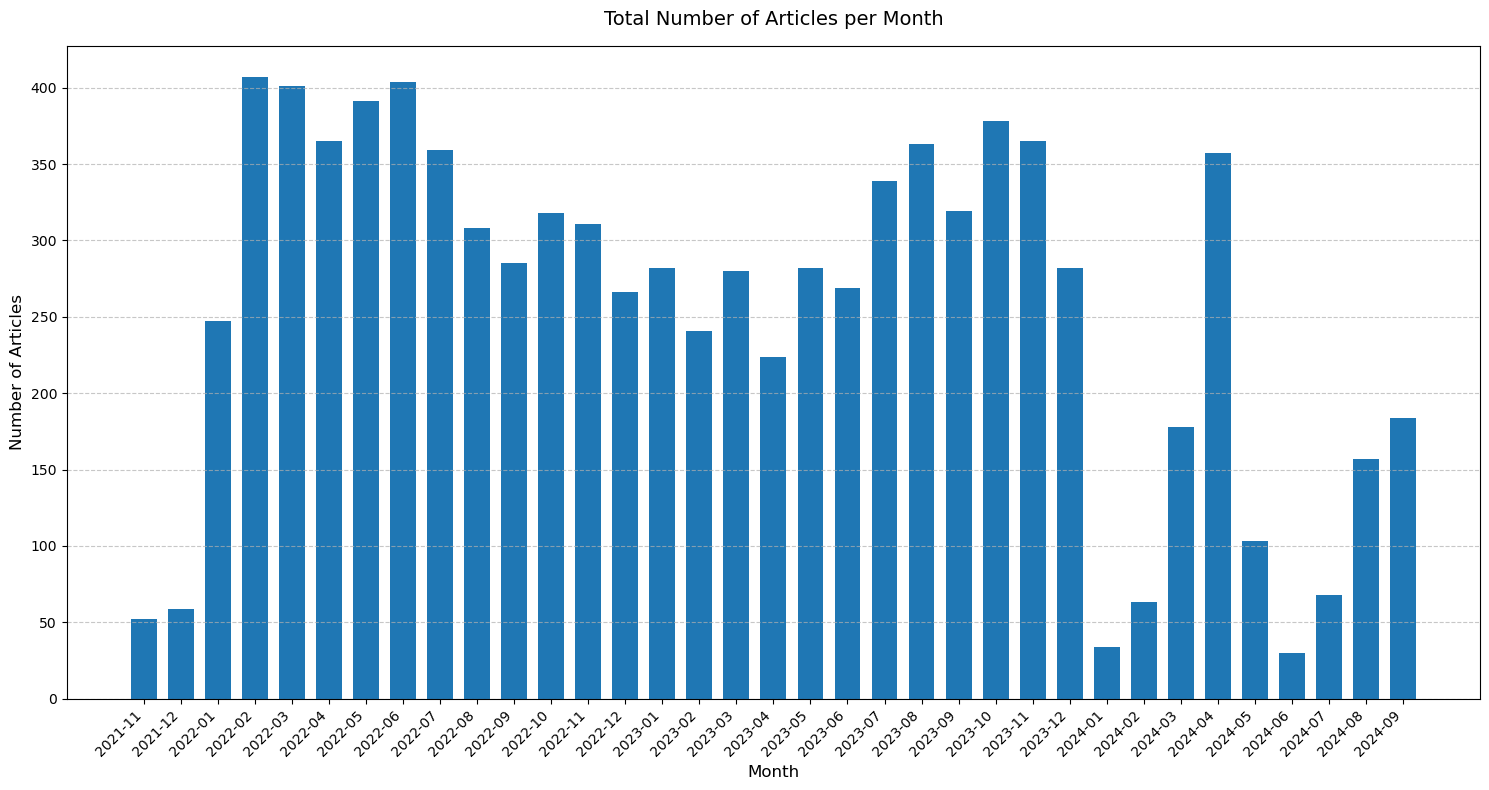

In [277]:
# Create monthly counts
monthly_df = exploratory_df.copy()
monthly_df['month'] = pd.to_datetime(monthly_df['date']).dt.strftime('%Y-%m')
monthly_counts = monthly_df.groupby('month').size()

# Create figure
plt.figure(figsize=(15, 8))

# Create bar plot
plt.bar(range(len(monthly_counts)), monthly_counts.values, width=0.7)

# Customize the plot
plt.title('Total Number of Articles per Month', fontsize=14, pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)

# Set x-axis ticks
plt.xticks(range(len(monthly_counts)), monthly_counts.index, rotation=45, ha='right')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Number of Positive/Negative/Neutral Articles

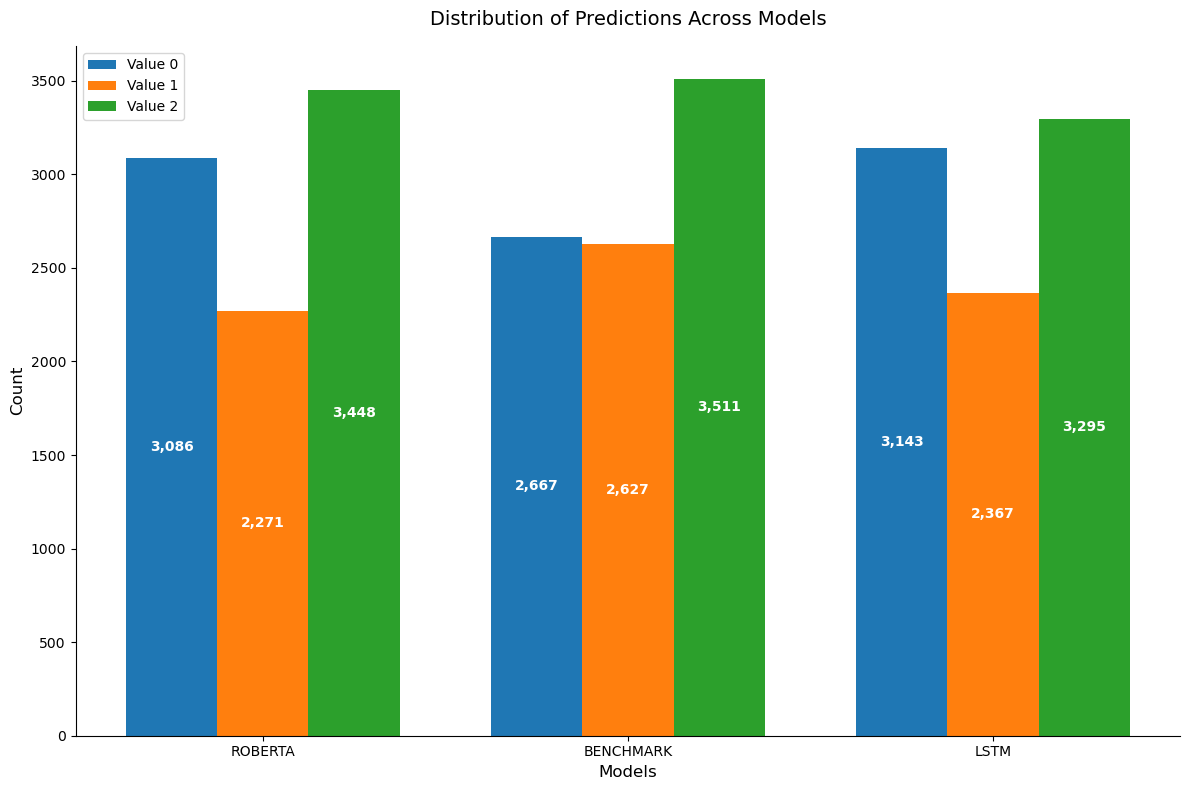

In [278]:
# Create figure with appropriate size
plt.figure(figsize=(12, 8))

# Get columns excluding 'date'
pred_columns = [col for col in exploratory_df.columns if col != 'date']

# Calculate value counts for each prediction column
counts_data = {col: exploratory_df[col].value_counts() for col in pred_columns}

# Create bar positions
x = np.arange(len(pred_columns))
width = 0.25

# Plot bars for each value (0, 1, 2)
for i, value in enumerate([0, 1, 2]):
    counts = [counts_data[col].get(value, 0) for col in pred_columns]
    bars = plt.bar(x + (i-1)*width, counts, width, label=f'Value {value}')
    
    # Add value labels inside the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height/2.,
                f'{int(height):,}',
                ha='center', va='center', color='white', fontweight='bold')

# Customize the plot
plt.title('Distribution of Predictions Across Models', fontsize=14, pad=15)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(x, [col.replace('_pred', '').upper() for col in pred_columns])
plt.legend()

# Remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Number of Positive/Negative/Neutral Articles per month

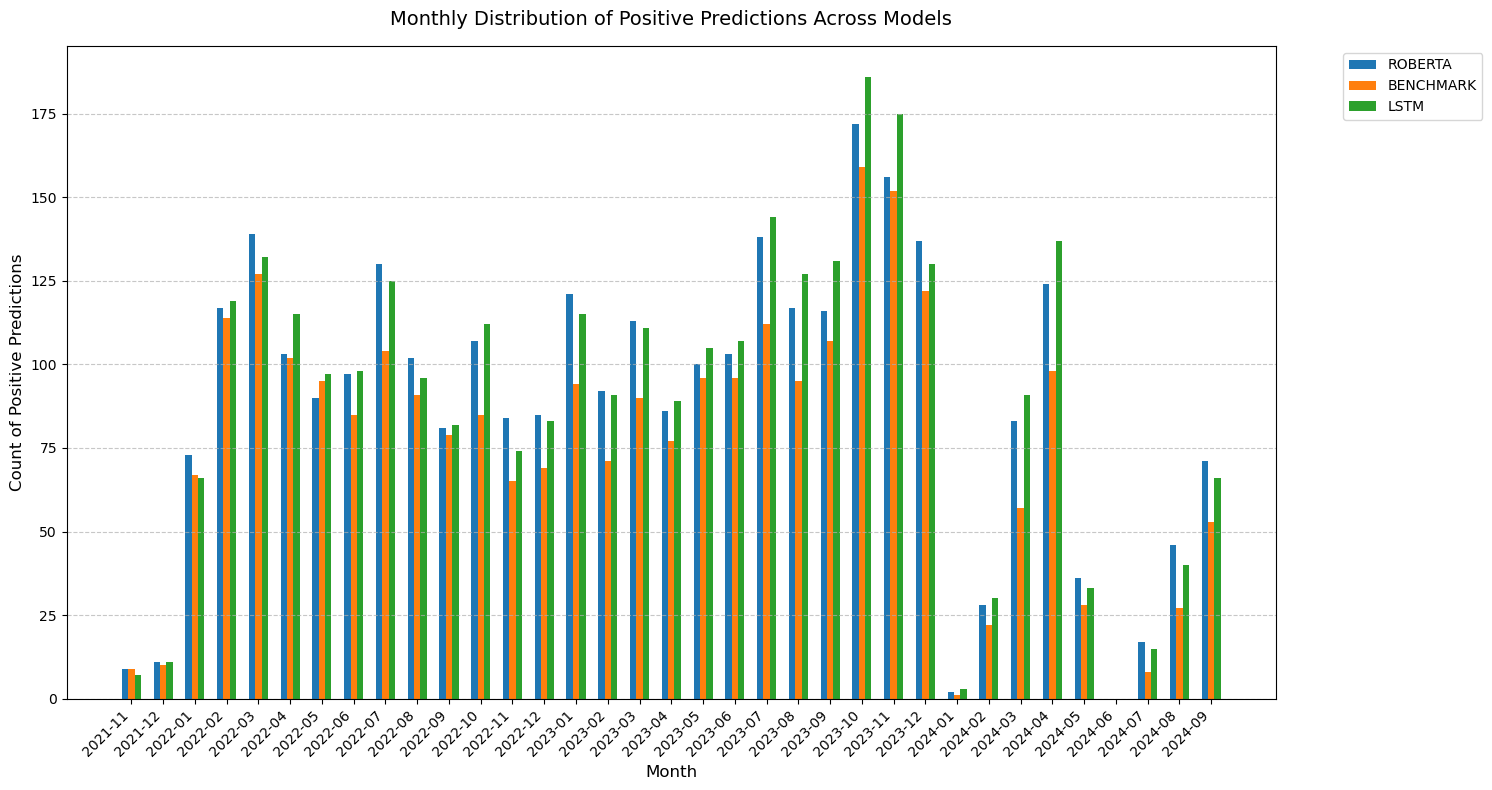

In [279]:
# Create a copy and extract month from date
monthly_df = exploratory_df.copy()
monthly_df['month'] = pd.to_datetime(monthly_df['date']).dt.strftime('%Y-%m')

# Get columns excluding 'date' and 'month'
pred_columns = [col for col in monthly_df.columns if col not in ['date', 'month']]

# Calculate monthly counts of positive predictions (0) for each model
monthly_counts = {}
for col in pred_columns:
    monthly_counts[col] = monthly_df[monthly_df[col] == 0].groupby('month').size()

# Create figure with appropriate size
plt.figure(figsize=(15, 8))

# Create bar positions
months = sorted(monthly_df['month'].unique())
x = np.arange(len(months))
width = 0.2  # Adjust based on number of models

# Plot bars for each model
for i, (model, counts) in enumerate(monthly_counts.items()):
    # Ensure counts exist for all months (fill with 0 if missing)
    model_counts = [counts.get(month, 0) for month in months]
    plt.bar(x + (i-len(pred_columns)/2+0.5)*width, model_counts, width, 
            label=model.replace('_pred', '').upper())

# Customize the plot
plt.title('Monthly Distribution of Positive Predictions Across Models', fontsize=14, pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count of Positive Predictions', fontsize=12)

# Set x-axis ticks
plt.xticks(x, months, rotation=45, ha='right')

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

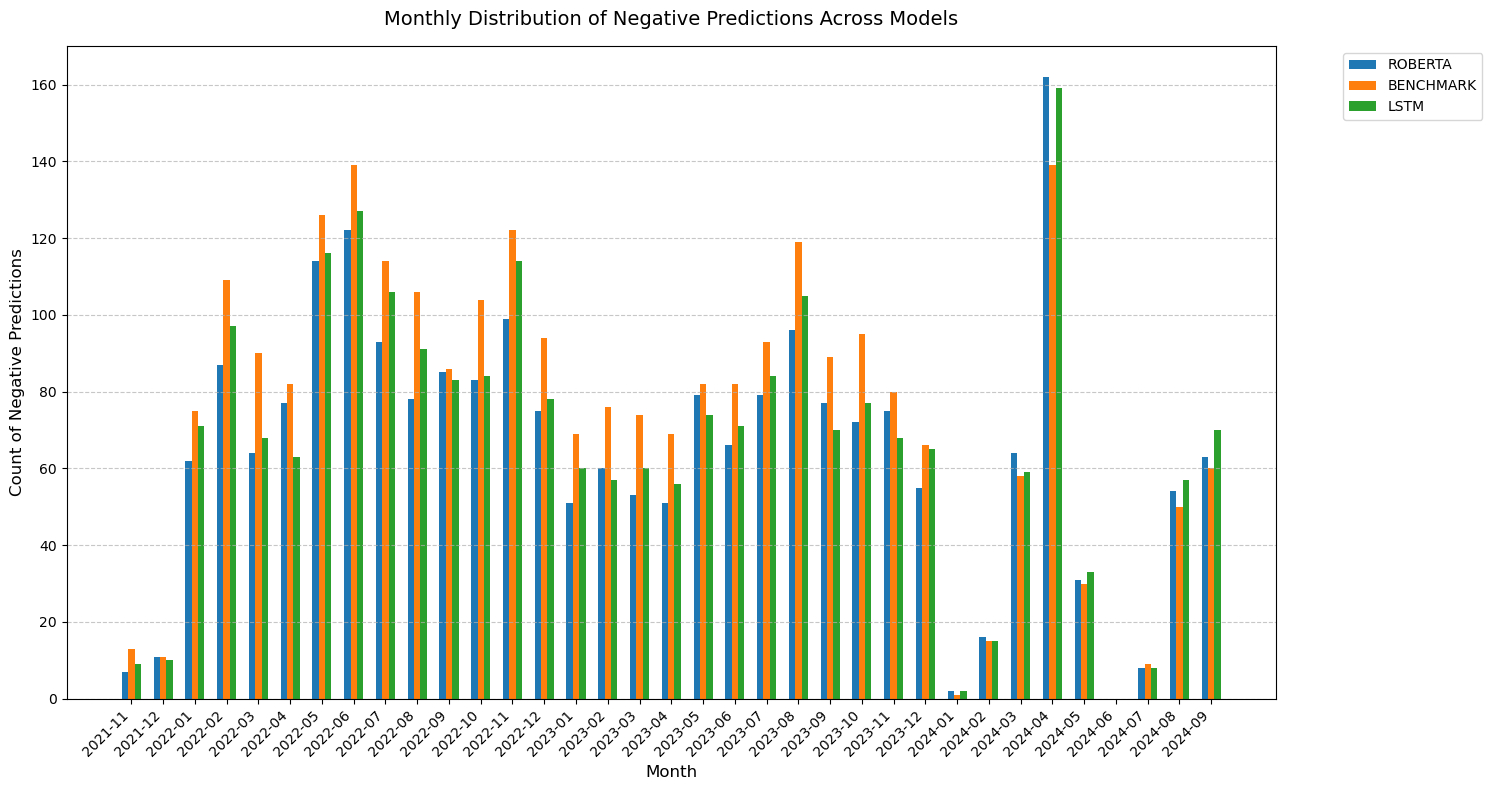

In [280]:
# Create a copy and extract month from date
monthly_df = exploratory_df.copy()
monthly_df['month'] = pd.to_datetime(monthly_df['date']).dt.strftime('%Y-%m')

# Get columns excluding 'date' and 'month'
pred_columns = [col for col in monthly_df.columns if col not in ['date', 'month']]

# Calculate monthly counts of negative predictions (1) for each model
monthly_counts = {}
for col in pred_columns:
    monthly_counts[col] = monthly_df[monthly_df[col] == 1].groupby('month').size()

# Create figure with appropriate size
plt.figure(figsize=(15, 8))

# Create bar positions
months = sorted(monthly_df['month'].unique())
x = np.arange(len(months))
width = 0.2  # Adjust based on number of models

# Plot bars for each model
for i, (model, counts) in enumerate(monthly_counts.items()):
    # Ensure counts exist for all months (fill with 0 if missing)
    model_counts = [counts.get(month, 0) for month in months]
    plt.bar(x + (i-len(pred_columns)/2+0.5)*width, model_counts, width, 
            label=model.replace('_pred', '').upper())

# Customize the plot
plt.title('Monthly Distribution of Negative Predictions Across Models', fontsize=14, pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count of Negative Predictions', fontsize=12)

# Set x-axis ticks
plt.xticks(x, months, rotation=45, ha='right')

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

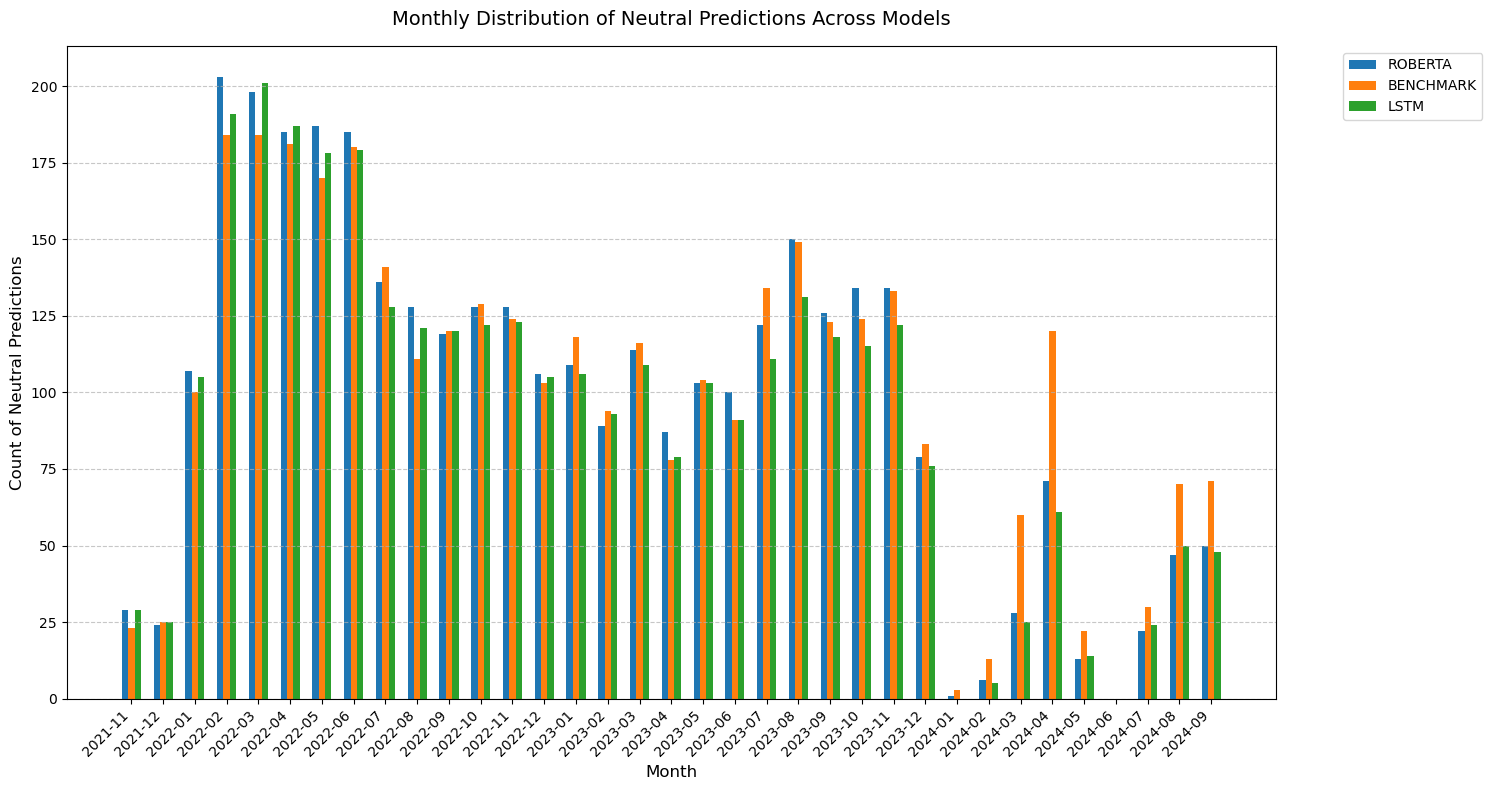

In [281]:
# Create a copy and extract month from date
monthly_df = exploratory_df.copy()
monthly_df['month'] = pd.to_datetime(monthly_df['date']).dt.strftime('%Y-%m')

# Get columns excluding 'date' and 'month'
pred_columns = [col for col in monthly_df.columns if col not in ['date', 'month']]

# Calculate monthly counts of neutral predictions (2) for each model
monthly_counts = {}
for col in pred_columns:
    monthly_counts[col] = monthly_df[monthly_df[col] == 2].groupby('month').size()

# Create figure with appropriate size
plt.figure(figsize=(15, 8))

# Create bar positions
months = sorted(monthly_df['month'].unique())
x = np.arange(len(months))
width = 0.2  # Adjust based on number of models

# Plot bars for each model
for i, (model, counts) in enumerate(monthly_counts.items()):
    # Ensure counts exist for all months (fill with 0 if missing)
    model_counts = [counts.get(month, 0) for month in months]
    plt.bar(x + (i-len(pred_columns)/2+0.5)*width, model_counts, width, 
            label=model.replace('_pred', '').upper())

# Customize the plot
plt.title('Monthly Distribution of Neutral Predictions Across Models', fontsize=14, pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count of Neutral Predictions', fontsize=12)

# Set x-axis ticks
plt.xticks(x, months, rotation=45, ha='right')

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

### % Positive over Time

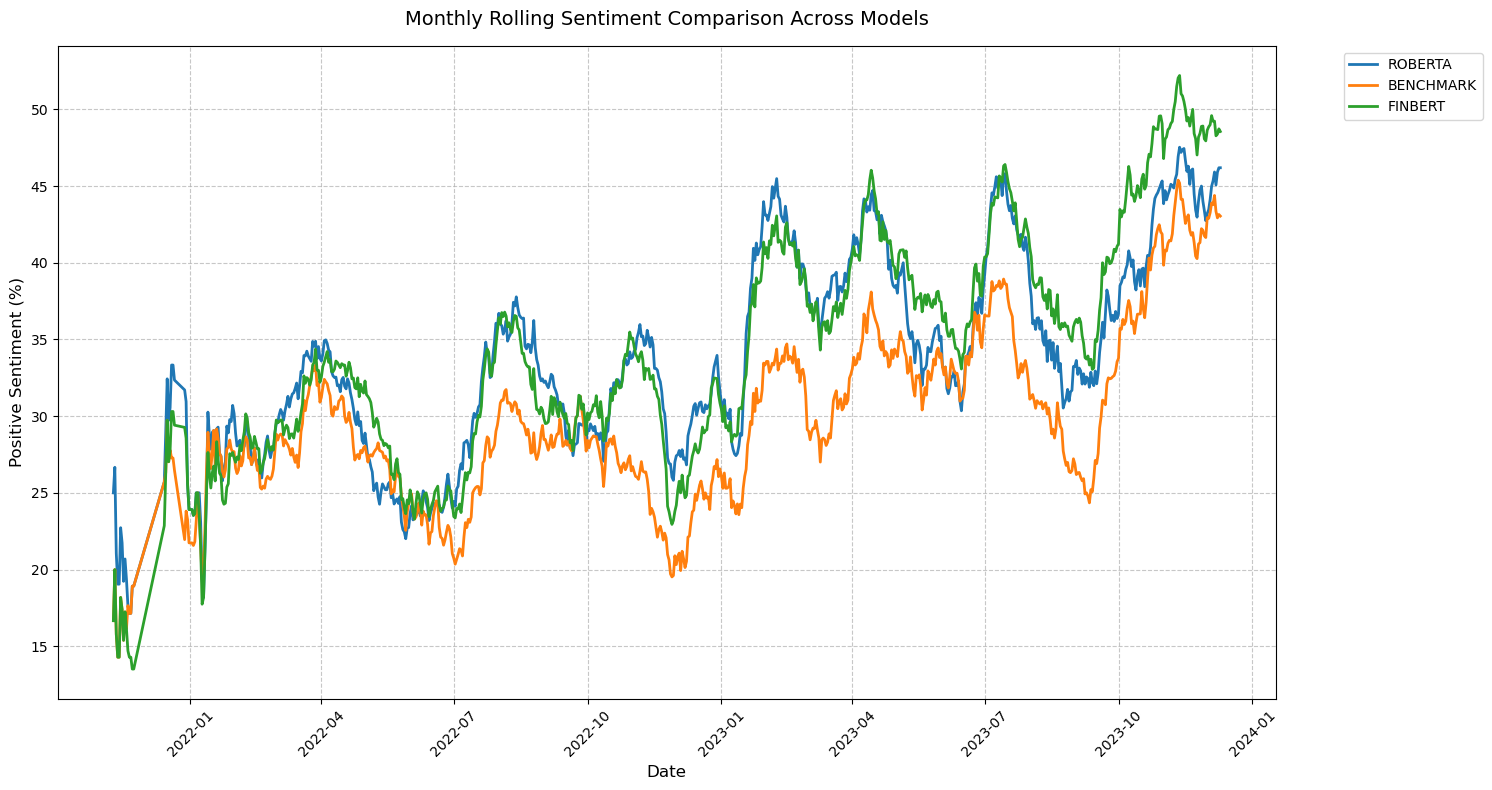

In [282]:
# Create figure with appropriate size
plt.figure(figsize=(15, 8))

# Plot monthly rolling sentiment for each model
for name, df in merged_dfs.items():
    plt.plot(df['date'], df['rolling_monthly'], label=name.upper(), linewidth=2)

# Customize the plot
plt.title('Monthly Rolling Sentiment Comparison Across Models', fontsize=14, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Positive Sentiment (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

### % Negative over Time

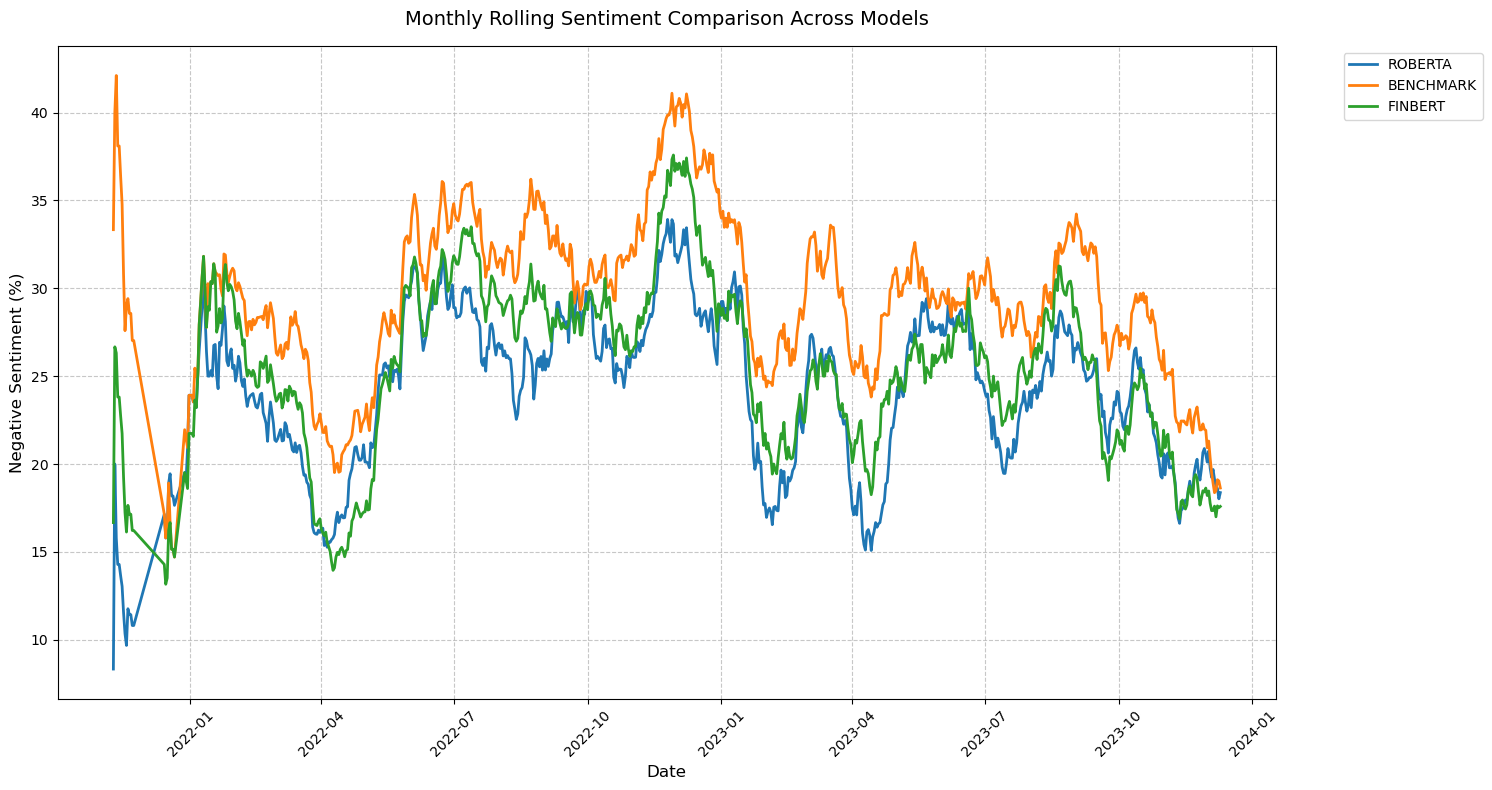

In [283]:
# Create figure with appropriate size
plt.figure(figsize=(15, 8))

# Plot monthly rolling sentiment for each model
for name, df in merged_dfs.items():
    plt.plot(df['date'], df['rolling_monthly_neg'], label=name.upper(), linewidth=2)

# Customize the plot
plt.title('Monthly Rolling Sentiment Comparison Across Models', fontsize=14, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Negative Sentiment (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

## Correlation Analysis

In [284]:
def plot_correlation_matrix(merged_df, figsize=(20, 16), title="Triangular Correlation Matrix"):
    """
    Create and plot a correlation matrix for sentiment, returns, and technical indicators.
    
    Args:
        merged_df (pd.DataFrame): Merged dataframe containing sentiment and price data
        figsize (tuple): Figure size for the plot (default: (20, 16))
        title (str): Title for the correlation matrix plot (default: "Triangular Correlation Matrix")
    """
    # Define variables for correlation matrix
    variables = [
        #"rolling_monthly",      # Positive Sentiment
        #"rolling_monthly_neg",  # Negative Sentiment
        "Return_M1", # (Future returns "Return_D1", "Return_W1", "Return_Q1", "Return_Y1")
        #"Return_M1_H",  # Historical returns
        "EMA","RSI", "MACD_signal" # Technical Indicators "RSI", "MACD_signal",
        #"prev_month_change"
    ]
    
    # Calculate the correlation matrix
    correlation_matrix = merged_df[variables].corr()
    
    # Plot the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(title)
    plt.show()
    
    return correlation_matrix

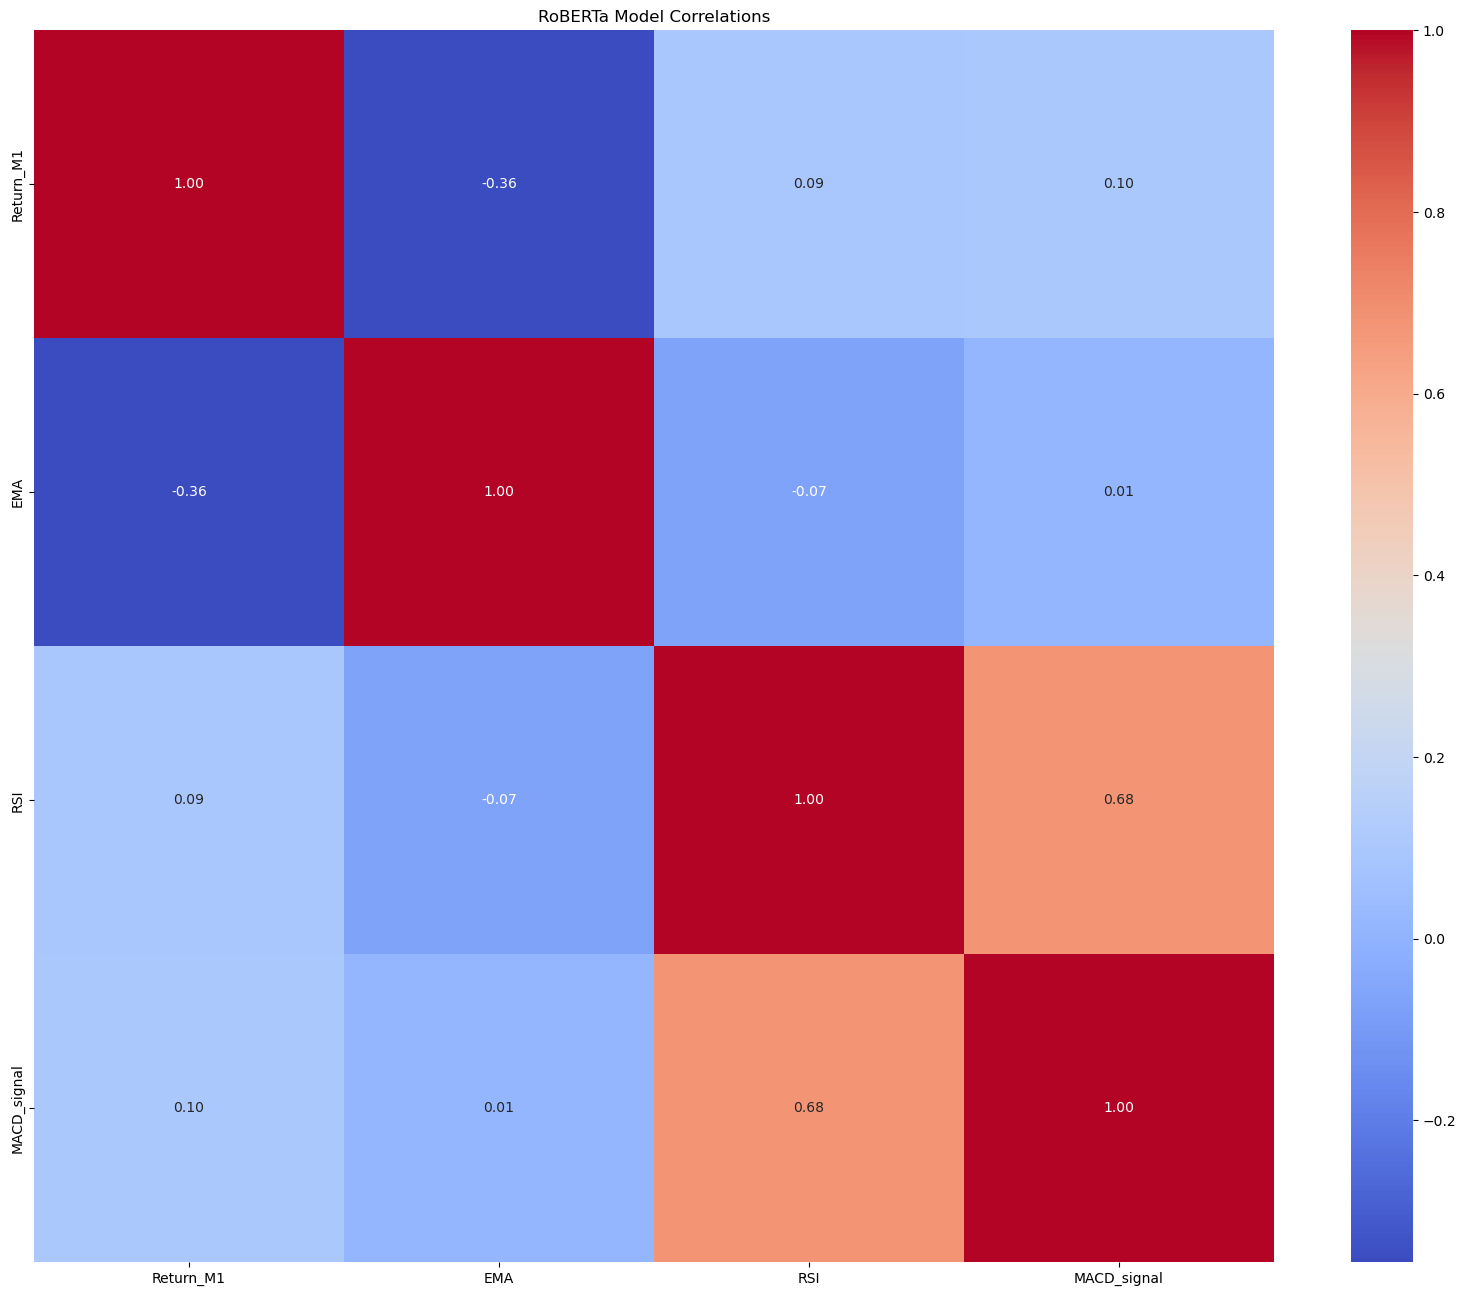

,Return_M1,EMA,RSI,MACD_signal
Return_M1,1.000000,-0.356105,0.093480,0.100180
EMA,-0.356105,1.000000,-0.065763,0.012151
RSI,0.093480,-0.065763,1.000000,0.677356
MACD_signal,0.100180,0.012151,0.677356,1.000000


In [285]:
# For RoBERTa
plot_correlation_matrix(merged_dfs['roberta'], title="RoBERTa Model Correlations")

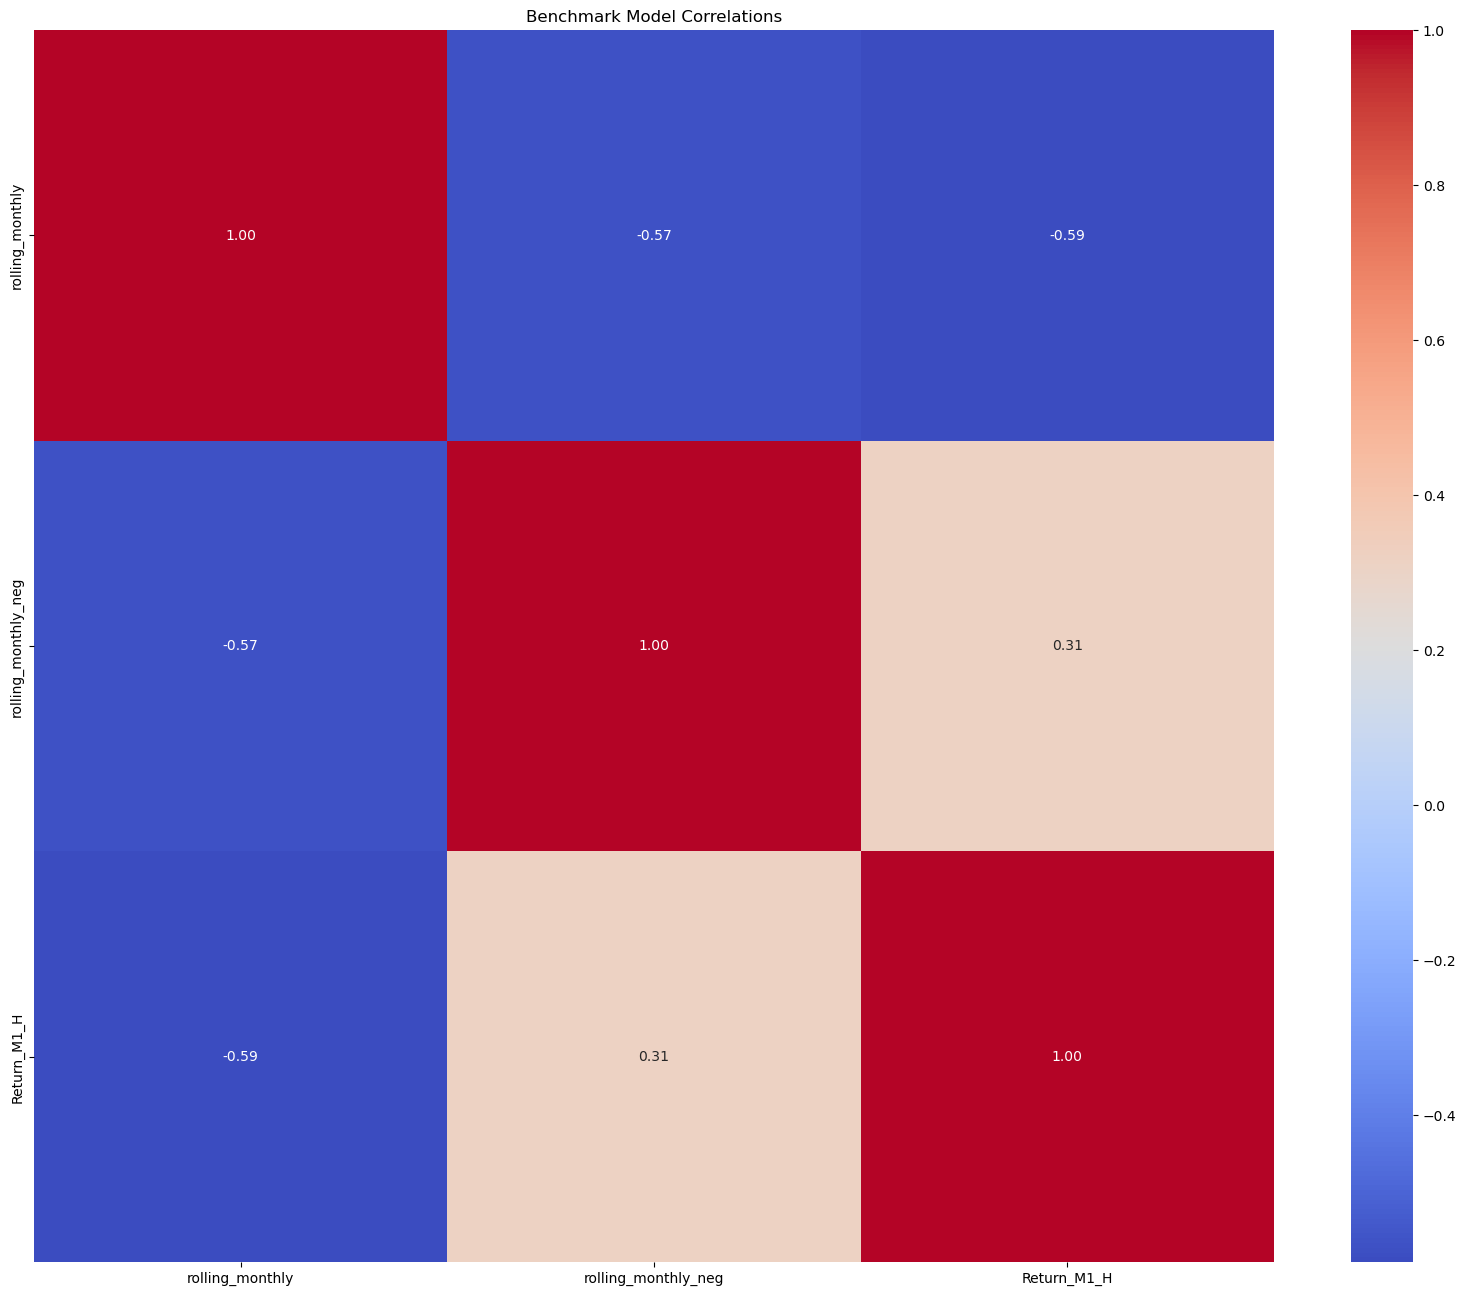

,rolling_monthly,rolling_monthly_neg,Return_M1_H
rolling_monthly,1.000000,-0.569522,-0.589541
rolling_monthly_neg,-0.569522,1.000000,0.311778
Return_M1_H,-0.589541,0.311778,1.000000


In [252]:
# For benchmark
plot_correlation_matrix(merged_dfs['benchmark'], title="Benchmark Model Correlations")

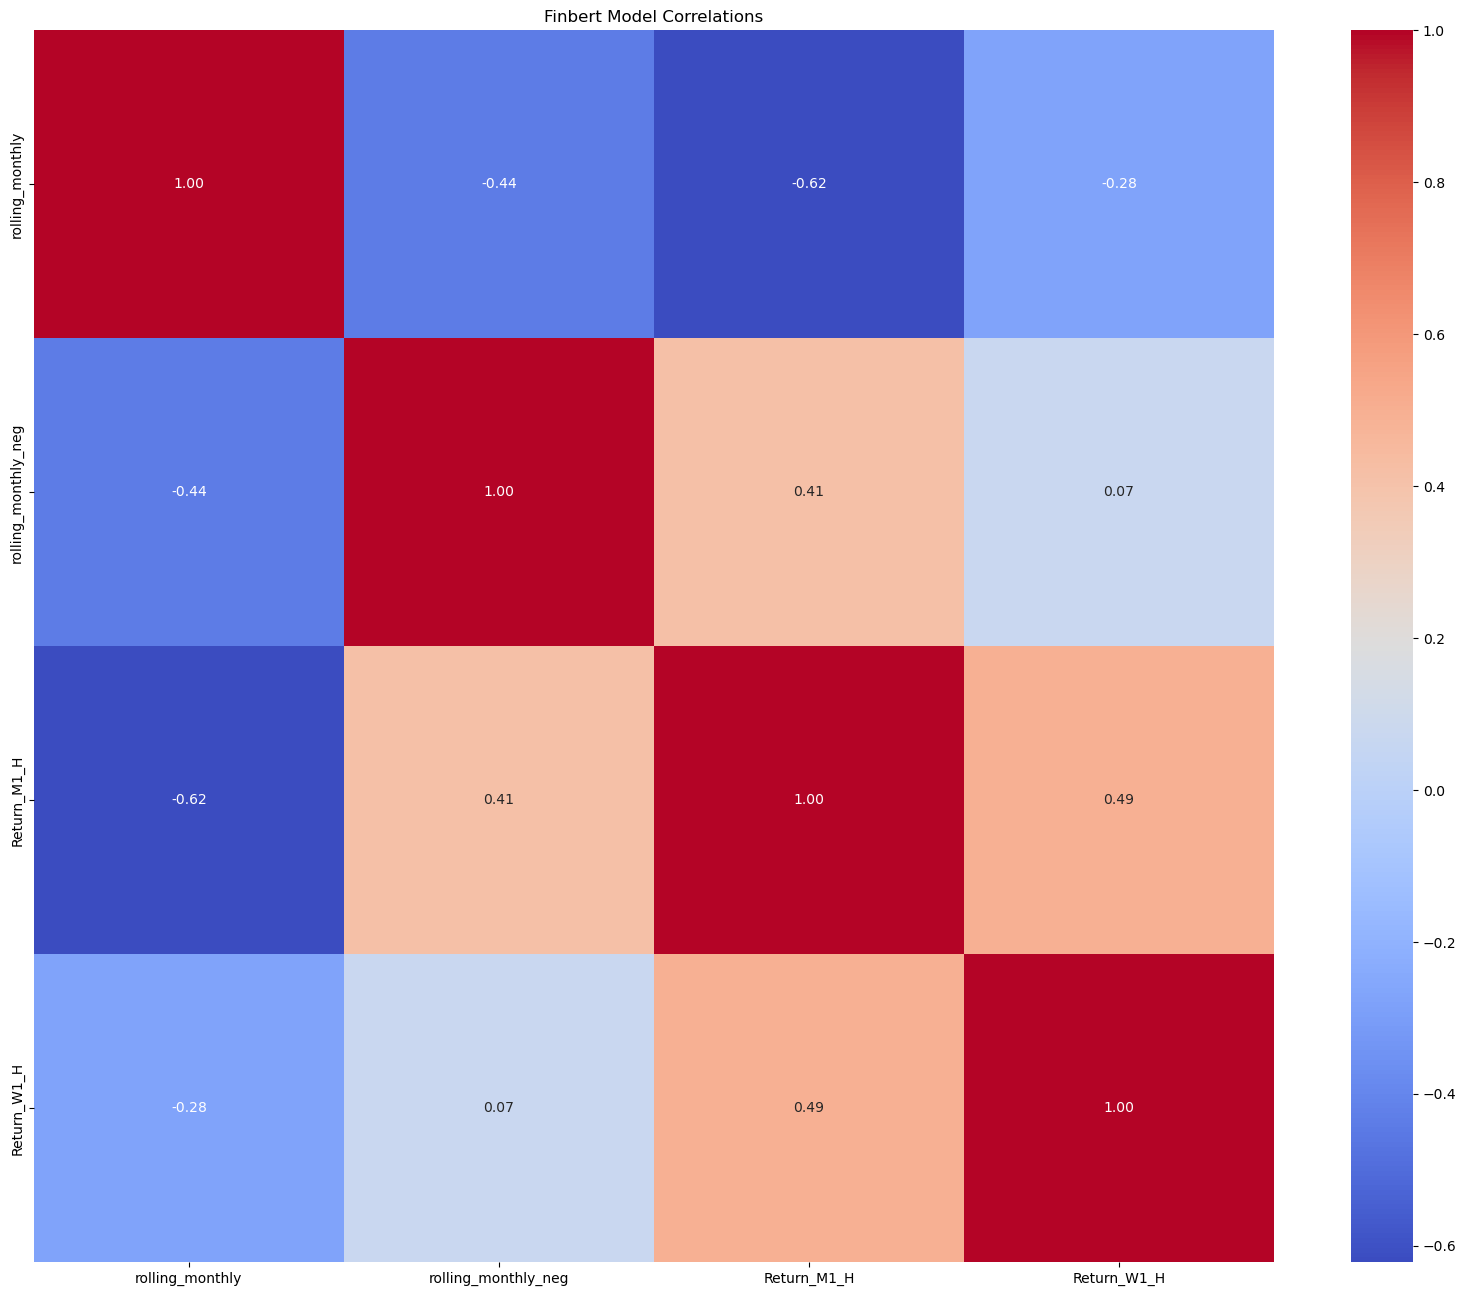

,rolling_monthly,rolling_monthly_neg,Return_M1_H,Return_W1_H
rolling_monthly,1.000000,-0.439524,-0.621607,-0.278092
rolling_monthly_neg,-0.439524,1.000000,0.412543,0.074340
Return_M1_H,-0.621607,0.412543,1.000000,0.493862
Return_W1_H,-0.278092,0.074340,0.493862,1.000000


In [249]:
# For Finbert
plot_correlation_matrix(merged_dfs['finbert'], title="Finbert Model Correlations")

## Model Training & Analysis

### Standard Linear Regression

In [289]:
def run_time_series_regression(df, feature_columns, target_column='Return_M1', n_splits=5, 
                             test_size_pct=0.2, show_plots=True, show_summaries=True,
                             standardize=False):
    """
    Run time series regression with cross-validation.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        feature_columns (list): List of feature column names
        target_column (str): Name of target column (default: 'Return_M1')
        n_splits (int): Number of splits for time series CV (default: 5)
        test_size_pct (float): Percentage of data for test set (default: 0.2)
        show_plots (bool): Whether to show visualization plots (default: True)
        show_summaries (bool): Whether to print regression summaries (default: True)
        standardize (bool): Whether to apply Z-score standardization (default: False)
    
    Returns:
        dict: Dictionary containing model performance metrics and predictions
    """
    
    # ... existing code ...
    
    # Prepare features and target
    X = sm.add_constant(df[feature_columns])
    y = df[target_column]
    
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=int(len(X) * test_size_pct))
    
    # Initialize StandardScaler if standardization is requested
    scaler = StandardScaler() if standardize else None
    
    # Prepare lists to store results
    all_predictions = []
    all_actuals = []
    r2_scores = []
    fold_metrics = []
    directional_accuracies = []  # New list to store directional accuracy for each fold
    
    # Perform Time Series cross-validation
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        # Split the data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        if standardize:
            # Standardize features (excluding constant)
            X_train_std = X_train.copy()
            X_test_std = X_test.copy()
            X_train_std[feature_columns] = scaler.fit_transform(X_train[feature_columns])
            X_test_std[feature_columns] = scaler.transform(X_test[feature_columns])
            
            # Use standardized data
            X_train_final = X_train_std
            X_test_final = X_test_std
        else:
            # Use original data
            X_train_final = X_train
            X_test_final = X_test
        
        # Fit the model
        model = sm.OLS(y_train, X_train_final).fit()
        
        # Generate predictions
        predictions = model.predict(X_test_final)
        
        # Calculate directional accuracy for this fold
        correct_direction = np.sum((predictions > 0) == (y_test > 0))
        directional_accuracy = correct_direction / len(predictions)
        directional_accuracies.append(directional_accuracy)
        
        # Store results
        all_predictions.extend(predictions)
        all_actuals.extend(y_test)
        r2_scores.append(model.rsquared)
        
        # Store fold metrics
        fold_metrics.append({
            'fold': fold + 1,
            'r2': model.rsquared,
            'train_size': len(X_train),
            'test_size': len(X_test),
            'directional_accuracy': directional_accuracy
        })
        
        # Print regression summary if enabled
        if show_summaries:
            print(f"Fold {fold + 1} Regression Summary:")
            print(model.summary())
            print(f"Directional Accuracy: {directional_accuracy:.4f}")
            print("\n")
    
    # Calculate metrics
    average_r2 = sum(r2_scores) / len(r2_scores)
    average_directional_accuracy = sum(directional_accuracies) / len(directional_accuracies)
    mse = mean_squared_error(all_actuals, all_predictions)
    mae = mean_absolute_error(all_actuals, all_predictions)
    rmse = mse ** 0.5
    
    # Calculate overall directional accuracy
    overall_correct_direction = np.sum((np.array(all_predictions) > 0) == (np.array(all_actuals) > 0))
    overall_directional_accuracy = overall_correct_direction / len(all_predictions)
    
    # Create visualization if enabled
    if show_plots:
        plt.figure(figsize=(10, 6))
        plt.scatter(all_actuals, all_predictions, alpha=0.5)
        plt.plot([min(all_actuals), max(all_actuals)], 
                [min(all_actuals), max(all_actuals)], 'r--', lw=2)
        plt.xlabel('Actual Returns')
        plt.ylabel('Predicted Returns')
        title = 'Actual vs Predicted Returns\nTime Series Cross-Validation'
        if standardize:
            title += '\nWith Z-score standardization'
        plt.title(title)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    
    # Print metrics
    print(f"\nAverage R^2 across all folds: {average_r2:.4f}")
    print(f"Average Directional Accuracy across folds: {average_directional_accuracy:.4f}")
    print(f"Overall Directional Accuracy: {overall_directional_accuracy:.4f}")
    print(f"Mean Squared Error: {mse:.6f}")
    print(f"Mean Absolute Error: {mae:.6f}")
    print(f"Root Mean Squared Error: {rmse:.6f}")
    
    # Return results
    return {
        'average_r2': average_r2,
        'average_directional_accuracy': average_directional_accuracy,
        'overall_directional_accuracy': overall_directional_accuracy,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2_scores': r2_scores,
        'directional_accuracies': directional_accuracies,
        'fold_metrics': fold_metrics,
        'predictions': all_predictions,
        'actuals': all_actuals
    }

### No sentiment (benchmark)

In [290]:
features = [ "RSI", "EMA", "prev_month_change"]
results = run_time_series_regression(
    df=merged_dfs['roberta'],
    feature_columns=features,
    target_column='Return_M1',
    n_splits=3 ,
    test_size_pct=0.2,
    show_plots=False,
    show_summaries=True,
    standardize=False
)

Fold 1 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     21.01
Date:                Sat, 18 Jan 2025   Prob (F-statistic):           2.38e-12
Time:                        16:59:34   Log-Likelihood:                 172.48
No. Observations:                 295   AIC:                            -337.0
Df Residuals:                     291   BIC:                            -322.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const      

### Sentiment Only

Roberta

In [291]:
features = ['rolling_monthly', "rolling_monthly_neg"]
results = run_time_series_regresssion(
    df=merged_dfs['roberta'],
    feature_columns=features,
    target_column='Return_M1',
    n_splits=3 ,
    test_size_pct=0.2,
    show_plots=False,
    show_summaries=True,
    standardize=False
)

Fold 1 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     20.72
Date:                Sat, 18 Jan 2025   Prob (F-statistic):           3.85e-09
Time:                        17:00:06   Log-Likelihood:                 163.13
No. Observations:                 295   AIC:                            -320.3
Df Residuals:                     292   BIC:                            -309.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const  

Benchmark

In [292]:
# Example usage:
features = ['rolling_monthly', "rolling_monthly_neg"]
results = run_time_series_regression(
    df=merged_dfs['benchmark'],
    feature_columns=features,
    target_column='Return_M1',
    n_splits=3 ,
    test_size_pct=0.2,
    show_plots=False,
    show_summaries=True,
    standardize=False
)

Fold 1 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     16.12
Date:                Sat, 18 Jan 2025   Prob (F-statistic):           2.29e-07
Time:                        17:00:29   Log-Likelihood:                 159.00
No. Observations:                 295   AIC:                            -312.0
Df Residuals:                     292   BIC:                            -300.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const  

Finbert

In [293]:
# Example usage:
features = ['rolling_monthly', "rolling_monthly_neg"]
results = run_time_series_regression(
    df=merged_dfs['finbert'],
    feature_columns=features,
    target_column='Return_M1',
    n_splits=3 ,
    test_size_pct=0.2,
    show_plots=False,
    show_summaries=True,
    standardize=False
)

Fold 1 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     35.34
Date:                Sat, 18 Jan 2025   Prob (F-statistic):           1.80e-14
Time:                        17:00:39   Log-Likelihood:                 175.53
No. Observations:                 295   AIC:                            -345.1
Df Residuals:                     292   BIC:                            -334.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const  

#### Complete model with article counts and technical indicators

Roberta

In [294]:
# Example usage:
features = ['rolling_monthly', "rolling_monthly_neg", "RSI", "EMA", "prev_month_change"]
results = run_time_series_regression(
    df=merged_dfs['roberta'],
    feature_columns=features,
    target_column='Return_M1',
    n_splits=3 ,
    test_size_pct=0.2,
    show_plots=False,
    show_summaries=True,
)

Fold 1 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     12.74
Date:                Sat, 18 Jan 2025   Prob (F-statistic):           3.35e-11
Time:                        17:00:50   Log-Likelihood:                 172.94
No. Observations:                 295   AIC:                            -333.9
Df Residuals:                     289   BIC:                            -311.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const  

Benchmark

In [295]:
features = ['rolling_monthly', "rolling_monthly_neg", "RSI", "EMA", "prev_month_change"]
results = run_time_series_regression(
    df=merged_dfs['benchmark'],
    feature_columns=features,
    target_column='Return_M1',
    n_splits=3 ,
    test_size_pct=0.2,
    show_plots=False,
    show_summaries=True
)

Fold 1 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     14.25
Date:                Sat, 18 Jan 2025   Prob (F-statistic):           1.79e-12
Time:                        17:00:56   Log-Likelihood:                 176.06
No. Observations:                 295   AIC:                            -340.1
Df Residuals:                     289   BIC:                            -318.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const  

Finbert

In [296]:
# Example usage:
features = ['rolling_monthly', "rolling_monthly_neg", "RSI", "EMA", "prev_month_change"]
results = run_time_series_regression(
    df=merged_dfs['finbert'],
    feature_columns=features,
    target_column='Return_M1',
    n_splits=3 ,
    test_size_pct=0.2,
    show_plots=False,
    show_summaries=True
)

Fold 1 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     17.78
Date:                Sat, 18 Jan 2025   Prob (F-statistic):           2.31e-15
Time:                        17:01:02   Log-Likelihood:                 183.11
No. Observations:                 295   AIC:                            -354.2
Df Residuals:                     289   BIC:                            -332.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const  

### Lasso/Ridge Linear Regression

#### Lasso

In [297]:
def run_lasso_regression(df, feature_columns, target_column='Return_M1', alpha=1.0, standardize=True):
    """
    Run Lasso regression without train-test split.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        feature_columns (list): List of feature column names
        target_column (str): Name of target column (default: 'Return_M1')
        alpha (float): Regularization strength (default: 1.0)
        standardize (bool): Whether to apply Z-score standardization (default: True)
    
    Returns:
        dict: Dictionary containing model performance metrics and coefficients
    """
    
    # Prepare features and target
    X = df[feature_columns]
    y = df[target_column]
    
    # Standardize if requested
    if standardize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    # Add constant
    X = sm.add_constant(X)
    
    # Fit Lasso regression
    model = Lasso(alpha=alpha)
    model.fit(X, y)
    
    # Generate predictions
    predictions = model.predict(X)
    
    # Calculate metrics
    r2 = r2_score(y, predictions)
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    rmse = mse ** 0.5
    
    # Print coefficients
    print("Model Coefficients:")
    print(f"Intercept: {model.intercept_:.6f}")
    for feat, coef in zip(feature_columns, model.coef_[1:]):  # Skip first coefficient as it's for constant
        print(f"{feat}: {coef:.6f}")
    
    # Print metrics
    print(f"\nModel Performance:")
    print(f"R^2 Score: {r2:.4f}")
    print(f"Mean Squared Error: {mse:.6f}")
    print(f"Mean Absolute Error: {mae:.6f}")
    print(f"Root Mean Squared Error: {rmse:.6f}")
    
    return {
        'r2': r2,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'coefficients': dict(zip(['intercept'] + feature_columns, 
                               [model.intercept_] + list(model.coef_[1:]))),
        'predictions': predictions
    }
    
# Running regression
results = run_lasso_regression(
    df=merged_dfs['roberta'],
    feature_columns=['rolling_monthly', 'rolling_monthly_neg',"prev_month_change", "RSI", "MACD_signal", "EMA", "Return_D1_H", "Return_W1_H"],
    alpha=0.01,  # adjust regularization strength as needed
    standardize=True
)

Model Coefficients:
Intercept: 0.008071
rolling_monthly: 0.038329
rolling_monthly_neg: 0.025988
prev_month_change: 0.005749
RSI: 0.000000
MACD_signal: 0.000000
EMA: -0.025869
Return_D1_H: -0.000000
Return_W1_H: 0.000000

Model Performance:
R^2 Score: 0.1884
Mean Squared Error: 0.021553
Mean Absolute Error: 0.118619
Root Mean Squared Error: 0.146811


#### Ridge

In [302]:
def run_ridge_regression(df, feature_columns, target_column='Return_M1', alpha=1.0, standardize=True):
    """
    Run Ridge regression without train-test split.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        feature_columns (list): List of feature column names
        target_column (str): Name of target column (default: 'Return_M1')
        alpha (float): Regularization strength (default: 1.0)
        standardize (bool): Whether to apply Z-score standardization (default: True)
    
    Returns:
        dict: Dictionary containing model performance metrics and coefficients
    """
    
    # Prepare features and target
    X = df[feature_columns]
    y = df[target_column]
    
    # Standardize if requested
    if standardize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    # Add constant
    X = sm.add_constant(X)
    
    # Fit Ridge regression
    model = Ridge(alpha=alpha)
    model.fit(X, y)
    
    # Generate predictions
    predictions = model.predict(X)
    
    # Calculate metrics
    r2 = r2_score(y, predictions)
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    rmse = mse ** 0.5
    
    # Print coefficients
    print("Model Coefficients:")
    print(f"Intercept: {model.intercept_:.6f}")
    for feat, coef in zip(feature_columns, model.coef_[1:]):  # Skip first coefficient as it's for constant
        print(f"{feat}: {coef:.6f}")
    
    # Print metrics
    print(f"\nModel Performance:")
    print(f"R^2 Score: {r2:.4f}")
    print(f"Mean Squared Error: {mse:.6f}")
    print(f"Mean Absolute Error: {mae:.6f}")
    print(f"Root Mean Squared Error: {rmse:.6f}")
    
    return {
        'r2': r2,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'coefficients': dict(zip(['intercept'] + feature_columns, 
                               [model.intercept_] + list(model.coef_[1:]))),
        'predictions': predictions
    }
    
    # Usage
results = run_ridge_regression(
    df=merged_dfs['roberta'],
    feature_columns=['rolling_monthly', 'rolling_monthly_neg', "EMA", "prev_month_change"],
    alpha=0.1,  # adjust regularization strength as needed
    standardize=True
)

Model Coefficients:
Intercept: 0.008071
rolling_monthly: 0.059154
rolling_monthly_neg: 0.043677
EMA: -0.025231
prev_month_change: 0.018965

Model Performance:
R^2 Score: 0.2076
Mean Squared Error: 0.021042
Mean Absolute Error: 0.117990
Root Mean Squared Error: 0.145060


### LSTM

#### Model...

In [301]:
# Example usage
results = run_time_series_lstm(
    df=merged_dfs['roberta'],
    feature_columns=['rolling_monthly', 'rolling_monthly_neg', 'RSI', 'EMA',"count_yearly_total", "count_quarterly_total"],
    epochs=50,
    batch_size=32,
    n_splits=3,
    test_size_pct=0.2,
    show_plots=False,
    show_summaries=True
)

Epoch 1/50


c:\Users\laure\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0241 - mae: 0.1259
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0178 - mae: 0.1040 
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0175 - mae: 0.1024 
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0159 - mae: 0.0964 
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0151 - mae: 0.0951 
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139 - mae: 0.0911 
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0115 - mae: 0.0838 
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - mae: 0.0870 
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - mae: 0.0777 
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0099 - mae: 0.0768 
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0099 - mae: 0.0766 
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - mae: 0.0752 
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

c:\Users\laure\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0392 - mae: 0.1597
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0221 - mae: 0.1191 
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0196 - mae: 0.1117 
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182 - mae: 0.1088 
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0158 - mae: 0.1001 
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0171 - mae: 0.1049 
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0156 - mae: 0.0996 
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0157 - mae: 0.1001 
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0160 - mae: 0.1016 
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0149 - mae: 0.0988 
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0132 - mae: 0.0914 
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0137 - mae: 0.0931 
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

c:\Users\laure\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0300 - mae: 0.1353
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0194 - mae: 0.1103 
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165 - mae: 0.1037 
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153 - mae: 0.1016 
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - mae: 0.0987 
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160 - mae: 0.1026 
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145 - mae: 0.0995 
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142 - mae: 0.0971 
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135 - mae: 0.0935 
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - mae: 0.0909 
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121 - mae: 0.0889 
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124 - mae: 0.0897 
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

#### Model...

#### Model...